<a href="https://colab.research.google.com/github/cosimo-schiavoni/Massive_Data_Project/blob/main/Comics_Faces_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Check the connection to a GPU.

In [1]:
!nvidia-smi

Fri Sep  2 13:35:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the Kaggle package.

In [2]:
!pip install -q kaggle

Load the kaggle.json file in order to execute the download of the dataset. (Each user should upload his own file).

In [3]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


Import required libraries.

In [4]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras import optimizers, regularizers
from functools import reduce
import os
import zipfile
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import pickle
import shutil
import random
import skimage.io as io
from copy import deepcopy
from kaggle.api.kaggle_api_extended import KaggleApi
from tensorflow.keras import layers
import numpy as np

Download the dataset from a remote repository.

In [5]:
os.environ["data_source"] = "./Face_Comics_data"

api = KaggleApi()
api.authenticate()

if not os.path.exists(os.environ["data_source"]):
  os.makedirs(os.environ["data_source"])
  if "comic-faces-paired-synthetic-v2" not in os.listdir():
    if "comic-faces-paired-synthetic-v2.zip" not in os.listdir():
      ! kaggle datasets download -d defileroff/comic-faces-paired-synthetic-v2
      with zipfile.ZipFile("comic-faces-paired-synthetic-v2.zip", 'r') as f:
        f.extractall("comic-faces-paired-synthetic-v2")
    os.remove("comic-faces-paired-synthetic-v2.zip")


!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/comics" "./Face_Comics_data"
!mv "./comic-faces-paired-synthetic-v2/face2comics_v2.0.0_by_Sxela/face2comics_v2.0.0_by_Sxela/faces" "./Face_Comics_data"

!rm -rf comic-faces-paired-synthetic-v2

 99% 2.16G/2.18G [00:18<00:00, 142MB/s]
100% 2.18G/2.18G [00:18<00:00, 129MB/s]


Define data augmentation functions to be implemented in the analysis.

In [6]:
#data augmentation

@tf.function
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (180-x)
  else:
    x
  return x

###Randim invert
@tf.function 
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

#@tf.function 
class RandomInvert(layers.Layer):
  @tf.function 
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor
  @tf.function 
  def call(self, x):
    return random_invert_img(x)


###Kernel Inizializer Sobel_x
@tf.function 
def hedge_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [-5, -4, 0, 4, 5], 
            [-8, -10, 0, 10, 8], 
            [-10, -20, 0, 20, 10], 
            [-8, -10, 0, 10, 8], 
            [-5, -4, 0, 4, 5]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (5, 5, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def vertical_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 0, -1], 
            [1, 0, -1], 
            [1, 0, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

@tf.function 
def horizontal_detector(shape, dtype=None):
    print(shape)    
    sobel_x = tf.constant(
        [
            [1, 1, 1], 
            [0, 0, 0], 
            [-1, -1, -1]
        ], dtype=dtype )
    #create the missing dims.
    sobel_x = tf.reshape(sobel_x, (3, 3, 1, 1))

    print(tf.shape(sobel_x))
    #tile the last 2 axis to get the expected dims.
    sobel_x = tf.tile(sobel_x, (1, 1, shape[-2],shape[-1]))

    print(tf.shape(sobel_x))
    return sobel_x

Define the CNN model, the Training and the Validation dataset. 

In [104]:
def get_compiled_model(i):
  if i == 1:
    ###Create CNN (NORMAL MODEL)
    ##Initialize the CNN
    model_1 = tf.keras.models.Sequential()
          
    model_1.add(tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_1.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_1.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_1.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_1.add(tf.keras.layers.Flatten())
    #Full Connection
    model_1.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_1.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])
    return model_1

  elif i == 2:
    ###Create CNN (DROPOUT MODEL)
    ##Initialize the CNN
    model_2 = tf.keras.models.Sequential()
        
    model_2.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_2.add(tf.keras.layers.Conv2D(32, kernel_size=5, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu'))
    #Pooling
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_2.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu'))
    model_2.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Flattening
    model_2.add(tf.keras.layers.Flatten())
        #Full Connection
    model_2.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #DROPOUTS ok(0.1)
    model_2.add(tf.keras.layers.Dropout(0.1))
    #Output Layer
    model_2.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_2

  elif i == 3:
    ###Create CNN (L1 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_3 = tf.keras.models.Sequential()
        
    model_3.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))

    #Convolution
    model_3.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    #Pooling
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_3.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l1( l=0.01)))
    model_3.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_3.add(tf.keras.layers.Flatten())
    #Full Connection
    model_3.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_3.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))
    ###Training CNN
    ##Compiling the CNN
    model_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_3

  elif i == 4:
    ###Create CNN (L2 REGULARIZATION MODEL)
    ##Initialize the CNN
    model_4 = tf.keras.models.Sequential()
        
    model_4.add(tf.keras.Sequential([
      layers.RandomFlip("horizontal_and_vertical"),
      layers.RandomRotation(0.3),
      layers.RandomContrast(0.5, seed=None),
      RandomInvert(),
      layers.RandomZoom(height_factor=(-0.2, +0.3)),
      layers.RandomTranslation(height_factor=(-0.2, +0.3),width_factor=(-0.2, +0.3)),
      layers.Rescaling(1./255, offset= -1)
      ]))
    
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(32, kernel_size=5, kernel_initializer = hedge_detector, strides=2, activation='relu',  input_shape = [350,350,3]))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Convolution
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 3,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    #Pooling
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
    #Second Convolutional Layer
    model_4.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2,  strides=2, activation = 'relu',kernel_regularizer =tf.keras.regularizers.l2( l=0.01)))
    model_4.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=1, padding='same'))
    #Third Convolutional Layer
    #cnn.add(tf.keras.layers.Conv2D(filters = 32, kernel_size = 2, activation = 'relu'))
    #cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides=2))
    #Flattening
    model_4.add(tf.keras.layers.Flatten())
    #Full Connection
    model_4.add(tf.keras.layers.Dense(units = 128, activation = 'relu'))
    #Output Layer
    model_4.add(tf.keras.layers.Dense(units=1, activation = 'sigmoid'))

    ###Training CNN
    ##Compiling the CNN
    model_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy','mse'])

    return model_4

def get_dataset():
    BUFFER_SIZE = 10000

    BATCH_SIZE_PER_REPLICA = 64
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    data_dir= "./Face_Comics_data"

    file_count = sum(len(files) for _, _, files in os.walk(data_dir)) 
    print(file_count)

    tf.random.set_seed(123456)

    EPOCHS = 15
    IMG_SIZE = (350, 350)

    os.listdir(data_dir)


    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)


    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        validation_split=0.4,
        subset="validation",
        shuffle=True,
        seed=123456,
        image_size= IMG_SIZE,
        batch_size=BATCH_SIZE)
    
    val_batches = tf.data.experimental.cardinality(validation_dataset)
    test_dataset = validation_dataset.take(val_batches // 5)
    validation_dataset = validation_dataset.skip(val_batches // 5)
    print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
    print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
    print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

    AUTOTUNE = tf.data.AUTOTUNE

    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

    return (
        train_dataset,
        validation_dataset,
        test_dataset
    )

def AIC(n_examples, mse, n_model_parameters):
  AIC_SCORE = (n_examples * np.log(mse) ) + (2*n_model_parameters)
  return AIC_SCORE


Create a Mirrored strategy in order to distribute computation with Tensorflow engine.

In [92]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))


Number of devices: 1


In [98]:
MSE_list


[0.17901557683944702,
 0.1480422466993332,
 0.1967257261276245,
 0.1555105298757553,
 0.18232464790344238,
 0.12206842005252838,
 0.19360169768333435,
 0.1035357341170311]

In [113]:
Model_MSE = model_fit.history['mse']
AIC_list = []
Example_number = 1400 
Model_parameters_n = 425655

for mse_score in Model_MSE:
  AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
  AIC_list += AIC_SCORE
  print(AIC_SCORE)

[849059.966397186]
[848391.6151684147]


In [116]:
AIC_list

[849156.2709285403,
 848527.5888862917,
 849082.0537636109,
 848179.1306753779,
 849314.6124571873,
 849063.0607246634,
 849108.9522630009,
 848385.6621857816]

20000
Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 8000 files for validation.
Number of training batches: 219
Number of validation batches: 100
Number of test batches: 25
****************************** Model n.1 ******************************
Epoch 1/2
219/219 [==============================] - 110s 476ms/step - loss: 0.6163 - accuracy: 0.6364 - mse: 0.2117 - val_loss: 0.5899 - val_accuracy: 0.8250 - val_mse: 0.1994
Epoch 2/2
219/219 [==============================] - 104s 465ms/step - loss: 0.4167 - accuracy: 0.8050 - mse: 0.1351 - val_loss: 0.1457 - val_accuracy: 0.9695 - val_mse: 0.0355
Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_83 (Sequential)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_123 (Conv2D)         (None, 173

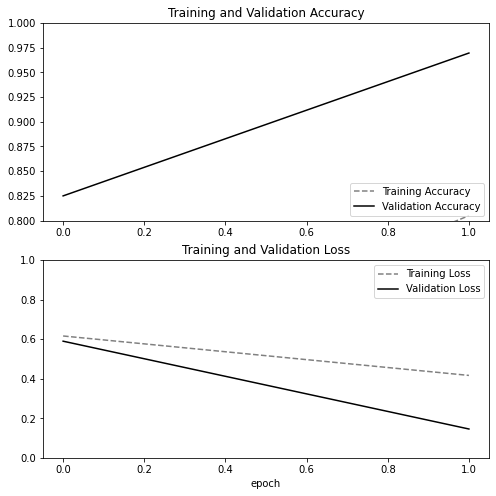

****************************** Model n.2 ******************************
Epoch 1/2
219/219 [==============================] - 110s 475ms/step - loss: 0.5805 - accuracy: 0.6599 - mse: 0.2008 - val_loss: 0.3218 - val_accuracy: 0.9123 - val_mse: 0.0942
Epoch 2/2
219/219 [==============================] - 104s 466ms/step - loss: 0.3268 - accuracy: 0.8511 - mse: 0.1053 - val_loss: 0.1542 - val_accuracy: 0.9461 - val_mse: 0.0428
Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_85 (Sequential)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_126 (Conv2D)         (None, 173, 173, 32)      2432      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 86, 86, 32)       0         
 ng2D)                                                           
                       

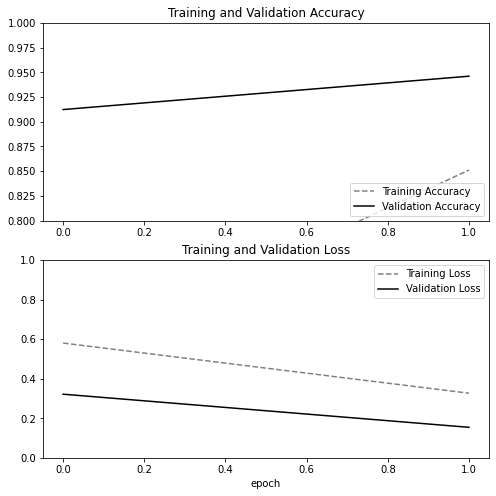

****************************** Model n.3 ******************************
Epoch 1/2
219/219 [==============================] - 109s 471ms/step - loss: 8.6323 - accuracy: 0.6583 - mse: 0.2370 - val_loss: 6.1648 - val_accuracy: 0.7409 - val_mse: 0.1902
Epoch 2/2
219/219 [==============================] - 104s 468ms/step - loss: 5.1870 - accuracy: 0.7564 - mse: 0.1980 - val_loss: 4.2448 - val_accuracy: 0.7627 - val_mse: 0.1767
Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_87 (Sequential)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_129 (Conv2D)         (None, 173, 173, 32)      2432      
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 86, 86, 32)       0         
 ng2D)                                                           
                       

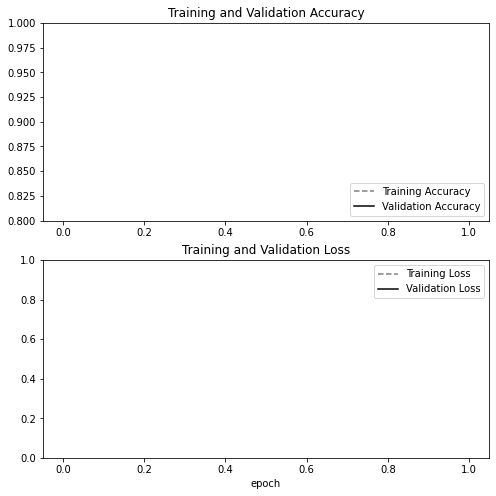

****************************** Model n.4 ******************************
Epoch 1/2
219/219 [==============================] - 108s 473ms/step - loss: 2.2643 - accuracy: 0.7076 - mse: 0.2046 - val_loss: 1.0488 - val_accuracy: 0.7481 - val_mse: 0.1679
Epoch 2/2
219/219 [==============================] - 104s 467ms/step - loss: 0.9087 - accuracy: 0.8333 - mse: 0.1221 - val_loss: 0.9106 - val_accuracy: 0.8191 - val_mse: 0.1302
Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_89 (Sequential)  (None, 350, 350, 3)       0         
                                                                 
 conv2d_132 (Conv2D)         (None, 173, 173, 32)      2432      
                                                                 
 max_pooling2d_132 (MaxPooli  (None, 86, 86, 32)       0         
 ng2D)                                                           
                       

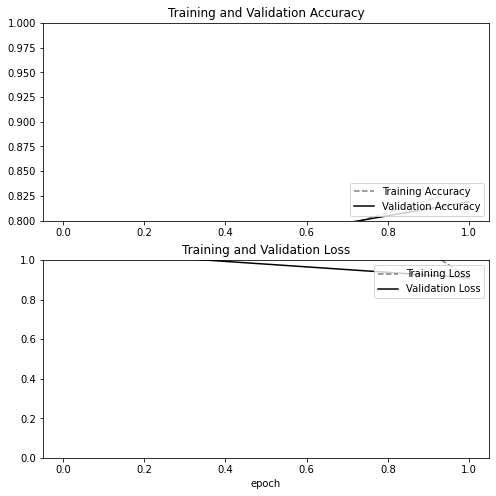

In [115]:
train_dataset, validation_dataset, test_dataset = get_dataset()

#Compute number of examples
Example_number = 1400

AIC_list = []
MSE_list = []
Models_parameters_n_list = []
for n in range(4):
  with strategy.scope():
    model = get_compiled_model(n+1)
    print(f'****************************** Model n.{n+1} ******************************')
    model_fit = model.fit(train_dataset, epochs=2, validation_data=validation_dataset)
    model_fit
    model.summary()

    #Retrieve MSE values for each epoch
    Model_MSE = model_fit.history['mse']
    MSE_list += model_fit.history['mse']

    #Retrieve Parameters numbers for each model
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))

    substring = 'Trainable params'

    c = 0
    for n in stringlist:
        if substring not in n:
          c += 1
        else:
          break

    substring = stringlist[c]  
    Model_parameters_n = int("".join([i for i in substring if i.isdigit()]))
    Models_parameters_n_list += [Model_parameters_n]

    #Aikaike Information Creterion (AIC) Computation
    for mse_score in Model_MSE:
      AIC_SCORE = [AIC(Example_number, mse_score , Model_parameters_n)]
      AIC_list += AIC_SCORE

    #Show training and validation graphs
    acc = model_fit.history['accuracy']
    val_acc = model_fit.history['val_accuracy']
    loss_ = model_fit.history['loss']
    val_loss_ = model_fit.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy', color = 'gray',linestyle='dashed')
    plt.plot(val_acc, label='Validation Accuracy', color = 'black')
    plt.ylim([0.8, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss_, label='Training Loss', color = 'gray',linestyle='dashed')
    plt.plot(val_loss_, label='Validation Loss', color = 'black')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()


IndexError: ignored

In [50]:
Models_parameters_n_list

[425665, 425665, 425665, 425665]

In [51]:
MSE_list

[0.21240438520908356,
 0.16758817434310913,
 0.1849108338356018,
 0.12095937877893448,
 0.18977706134319305,
 0.11675335466861725,
 0.2171614170074463,
 0.12831300497055054]

In [82]:
train_dataset = 1400
train_dataset

1400

In [80]:
AIC(train_dataset,0.2268851101398468, 425665)

830563.6388270156

Create a Strategy scope, and put the compiled model inside it.

Train the model on all available devices.

Test the model on all available devices.

In [44]:
mse = model_fit.history['mse']

In [81]:
mse

[0.19447827339172363, 0.10265888273715973]

In [ ]:
(14000 * np.log(0.2268851101398468) ) + (2*Model_parameters_n)
(14000 * np.log(0.17049580812454224) ) + (2*Model_parameters_n)


In [ ]:
model.evaluate(test_dataset)

In [78]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        shuffle=True,
        seed=123456)



Found 20000 files belonging to 2 classes.


Plot the Train and Validation loss and accuracy graph.